# Match Figures

John Curtin

## Set up environment

In [ ]:
options(conflicts.policy = "depends.ok")
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

## Load and format data

Load raw data for outcomes

In [ ]:
version <- "v5"
d <- read_csv(here::here(path_models, str_c("aim_2_", version, ".csv")),
              show_col_types = FALSE) |> 
  mutate(outcome_rct_wk4_num = if_else(outcome_rct_wk4 == "abstinent", 1, 0),
         outcome_rct_wk12_num = if_else(outcome_rct_wk12 == "abstinent", 1, 0),
         outcome_rct_wk26_num = if_else(outcome_rct_wk26 == "abstinent", 1, 0),
         tx_worst = case_when(
           prob_patch < prob_combo_nrt & prob_patch < prob_varenicline ~ "patch",
           prob_combo_nrt < prob_patch & prob_combo_nrt < prob_varenicline ~ "combo_nrt",
           prob_varenicline < prob_patch & prob_varenicline < prob_combo_nrt ~ "varenicline",
           TRUE ~ NA_character_),
         tx_second = case_when(
           tx_worst == "patch" & tx_best == "varenicline" ~ "combo_nrt",
           tx_worst == "patch" & tx_best == "combo_nrt" ~ "varenicline",
           tx_worst == "varenicline" & tx_best == "patch" ~ "combo_nrt",
           tx_worst == "varenicline" & tx_best == "combo_nrt" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "varenicline" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "patch" ~ "varenicline",
           TRUE ~ NA_character_)) |> 
  mutate(tx_rank = case_when(
    tx_rct == tx_best ~ "optimal",
    tx_rct == tx_second ~ "intermediate",
    tx_rct == tx_worst ~ "worst",
    TRUE ~ NA_character_)) |> 
  select(subid, starts_with("tx_"), starts_with("prob_"),
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) |> 
  glimpse()

Rows: 1,086
Columns: 14
$ subid                <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, …
$ tx_rct               <chr> "patch", "combo_nrt", "patch", "varenicline", "pa…
$ tx_best              <chr> "varenicline", "varenicline", "combo_nrt", "varen…
$ tx_match             <lgl> FALSE, FALSE, FALSE, TRUE, FALSE, FALSE, FALSE, F…
$ tx_worst             <chr> "combo_nrt", "patch", "patch", "patch", "patch", …
$ tx_second            <chr> "patch", "combo_nrt", "varenicline", "combo_nrt",…
$ tx_rank              <chr> "intermediate", "intermediate", "worst", "optimal…
$ prob_best            <dbl> 0.2646638, 0.4846121, 0.3136065, 0.4322435, 0.432…
$ prob_patch           <dbl> 0.2007715, 0.4175508, 0.2309921, 0.3847692, 0.313…
$ prob_combo_nrt       <dbl> 0.1845281, 0.4643572, 0.3136065, 0.3954174, 0.432…
$ prob_varenicline     <dbl> 0.2646638, 0.4846121, 0.2747510, 0.4322435, 0.422…
$ outcome_rct_wk4_num  <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0…
$ outcome_rct_wk

Make df for outcomes by predicted tx rank and wave

In [ ]:
d_rank <- d |> 
  select(subid, tx_rank, 
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) |> 
  pivot_longer(
    cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num),
    names_to = "week",
    names_pattern = "(?<=outcome_rct_)(.+)(?=_num)",
    values_to = "outcome") |> 
  summarize(outcome = mean(outcome), .by = c(tx_rank, week)) |> 
  rename (tx = tx_rank)

make df for outcomes by rct assigned tx and week

In [ ]:
d_tx <- d |> 
  select(subid, tx_rct, starts_with("outcome")) |> 
  pivot_longer(cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num),
               names_to = "week",
               names_pattern = "(?<=outcome_rct_)(.+)(?=_num)",
               values_to = "outcome") |> 
  group_by(tx_rct, week) |> 
    summarize(outcome = mean(outcome), .groups = "drop")

make df for outcomes by week collapsed across rct assigned tx (unweighted)

In [ ]:
d_week <- d |> 
  select(subid, tx_rct, starts_with("outcome")) |> 
  pivot_longer(cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, 
                        outcome_rct_wk26_num),
               names_to = "week",
               names_pattern = "(?<=outcome_rct_)(.+)(?=_num)",
               values_to = "outcome") |> 
  group_by(tx_rct, week) |> 
  summarize(outcome = mean(outcome), .groups = "drop") |> 
  group_by(week) |> 
  summarize(outcome = mean(outcome), .groups = "drop") |> 
  mutate(tx = "rct") |> 
  relocate(tx)

## Plot function

In [ ]:
plot_outcomes <- function(d) {
  
  d |> 
    mutate(tx = fct(tx, levels = c("rct", "optimal", "intermediate", "worst")),
           week = fct(week, levels = c("wk4", "wk12", "wk26"))) |> 
    ggplot(aes(x = week, y = outcome, fill = tx)) +
      geom_col(position = "dodge") +
      scale_fill_manual("Tx Received", 
                      values = c("rct" = "gray", "optimal" = "green", 
                                 "intermediate" = "blue", "worst" = "red")) +
    ylab("Abstinence (point prevalance)") +
    ylim(0, .47)
}

### AIM 2

A series of plots to unpack the result

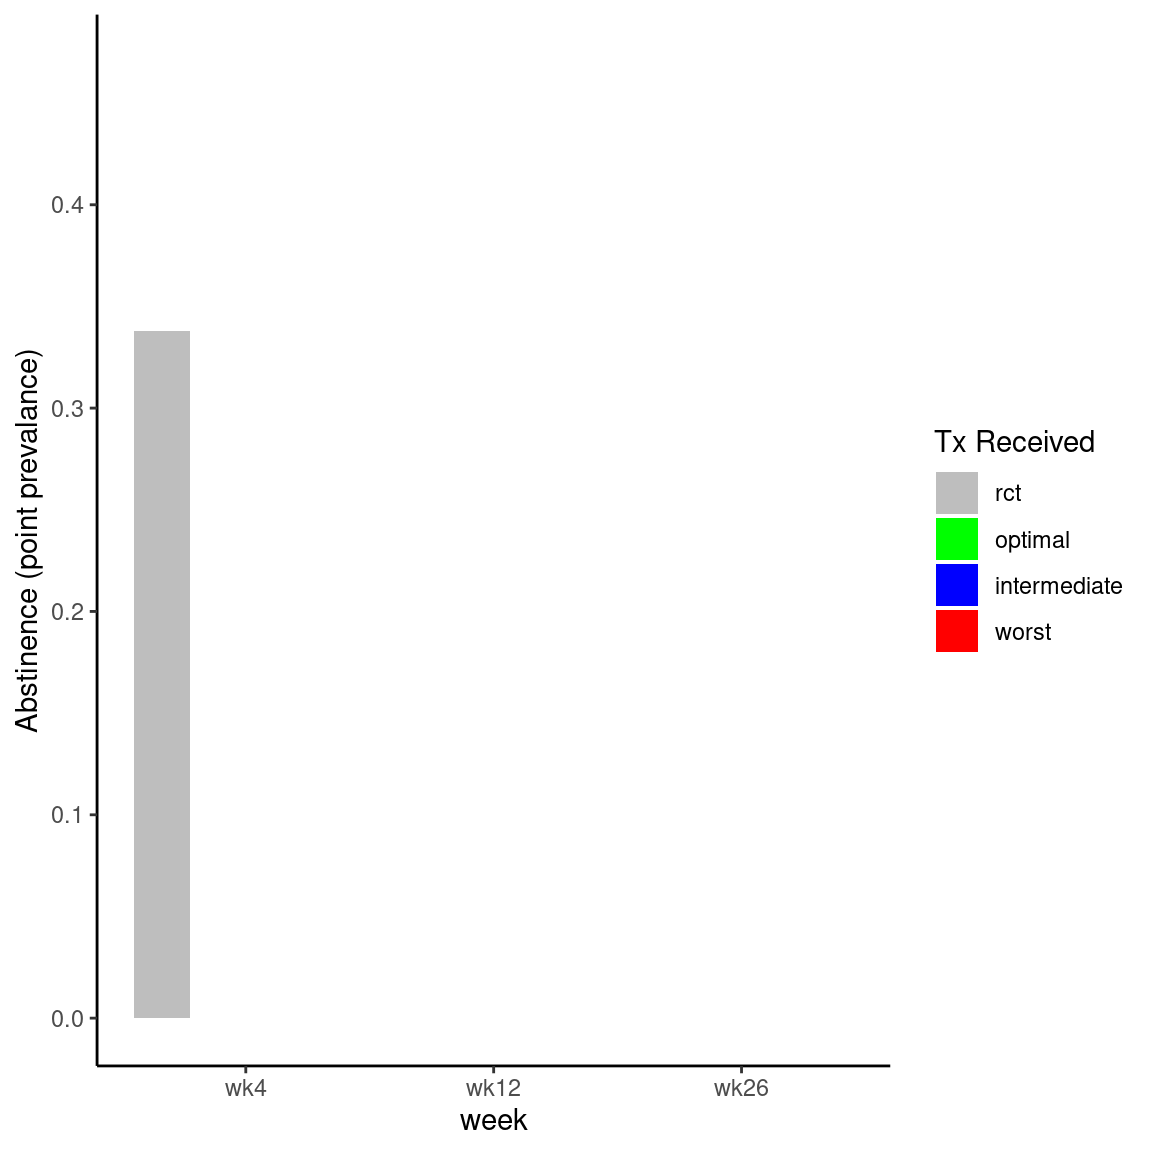

In [ ]:
#| label: fig-tx_week_1
#| fig-cap: "Abstince Rate over Time by Tx Received"
#| fig-height: 6
#| fig-width: 6

d_rank |>
  bind_rows(d_week) |>
  mutate(outcome = if_else(tx == "rct" & week == "wk4", outcome, 0)) |>
  plot_outcomes()

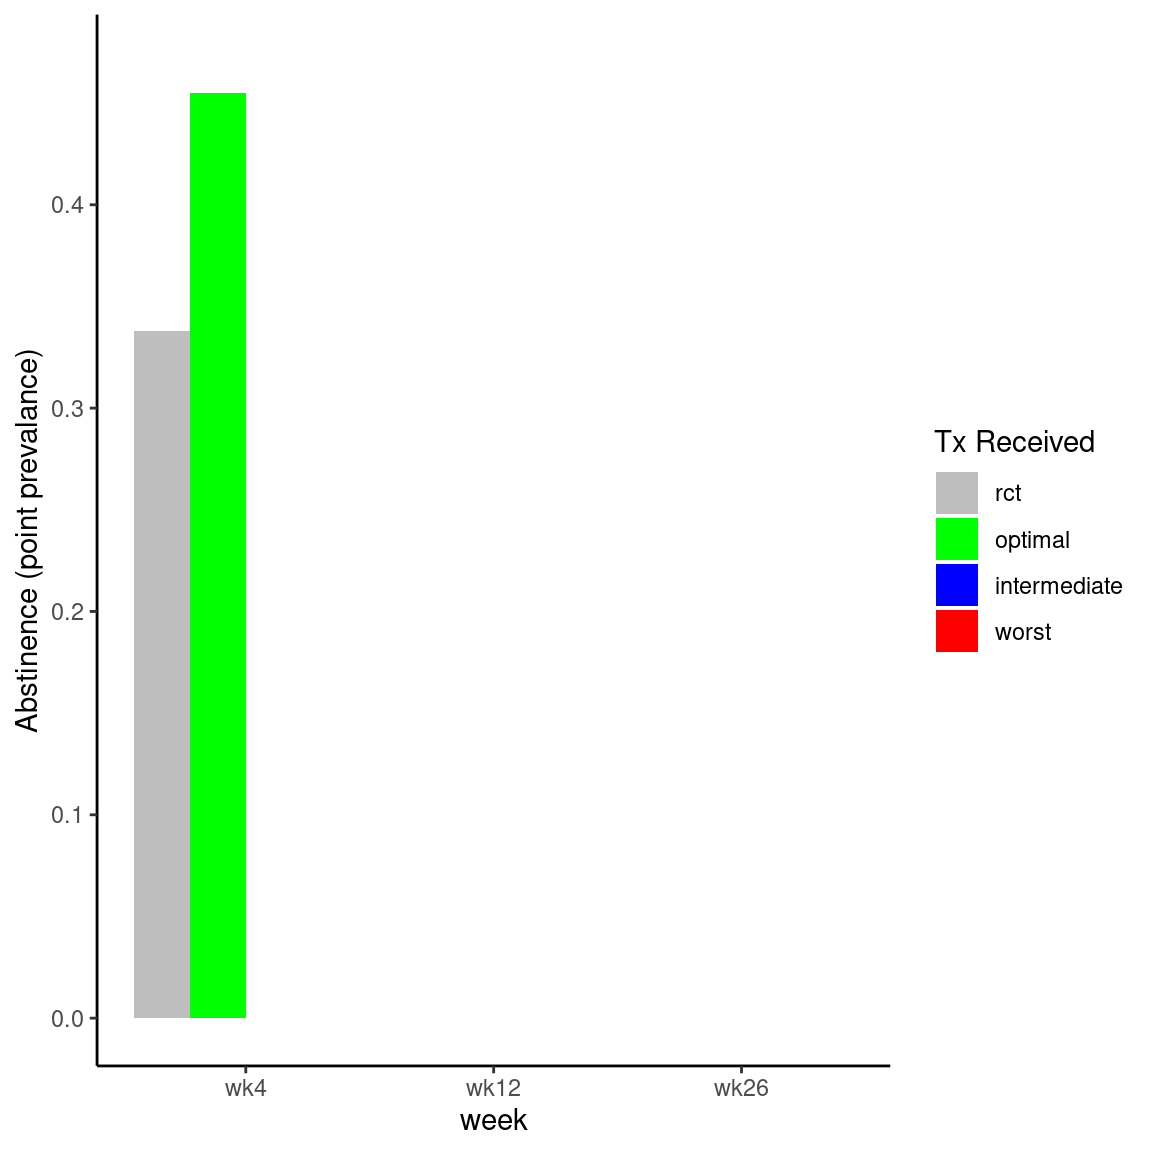

In [ ]:
#| label: fig-tx_week_2
#| fig-cap: "Abstince Rate over Time by Tx Received"
#| fig-height: 6
#| fig-width: 6

d_rank |> 
  bind_rows(d_week) |> 
  mutate(outcome = if_else((tx == "rct" | tx == "optimal") &
                            week == "wk4", outcome, 0)) |> 
  plot_outcomes()

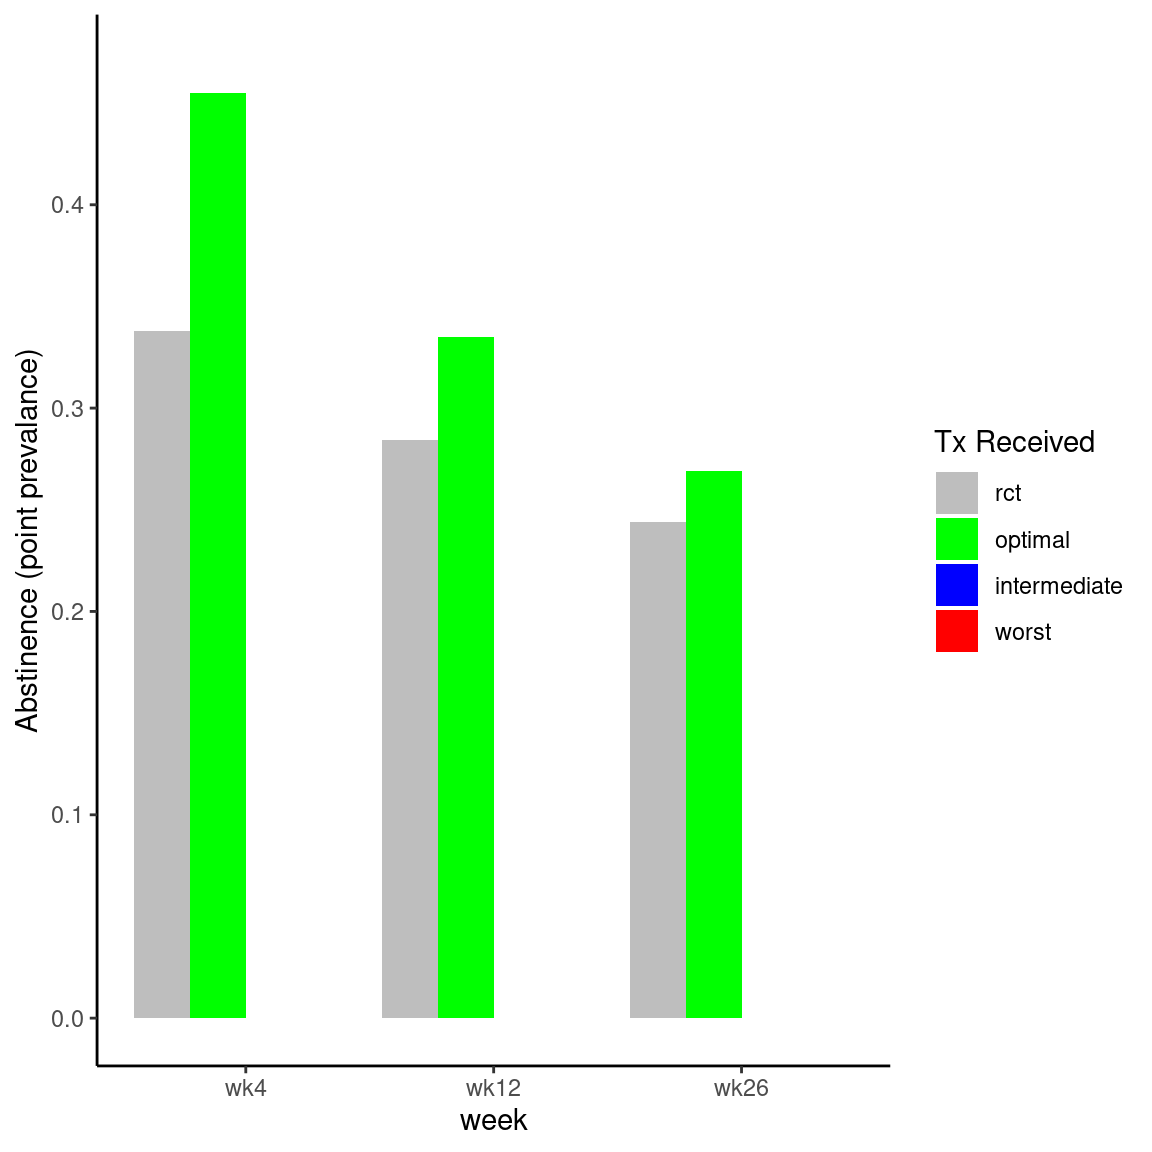

In [ ]:
#| label: fig-tx_week_3
#| fig-cap: "Abstince Rate over Time by Tx Received"
#| fig-height: 6
#| fig-width: 6

d_rank |> 
  bind_rows(d_week) |> 
  mutate(outcome = if_else(tx == "rct" | tx == "optimal", outcome, 0)) |> 
  plot_outcomes()

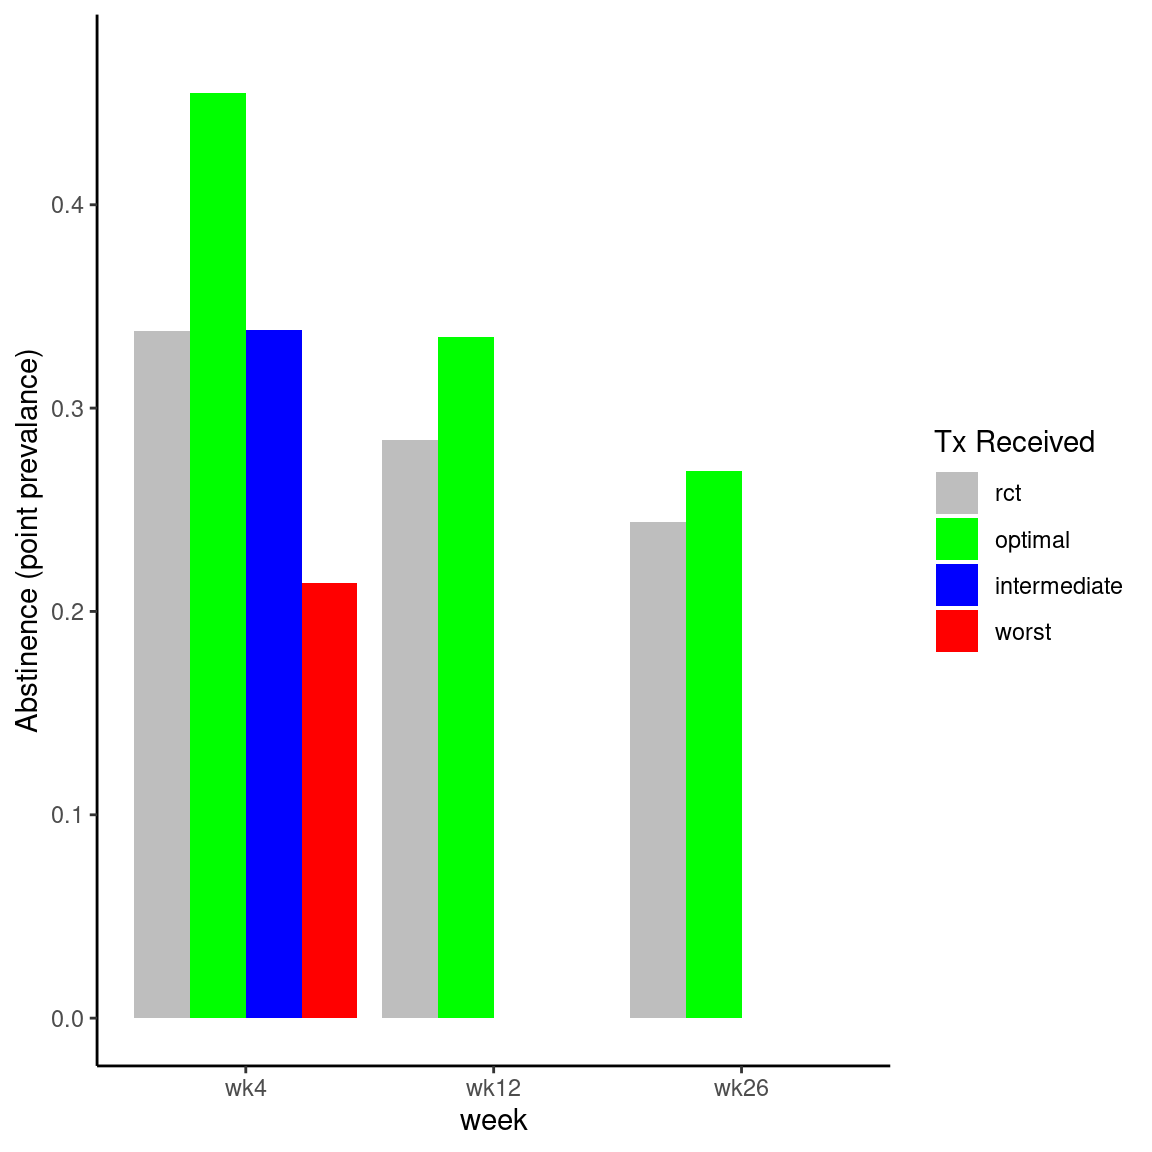

In [ ]:
#| label: fig-tx_week_4
#| fig-cap: "Abstince Rate over Time by Tx Received"
#| fig-height: 6
#| fig-width: 6

d_rank |> 
  bind_rows(d_week) |> 
  mutate(outcome = if_else(tx == "rct" | tx == "optimal" |
                           week == "wk4", outcome, 0)) |> 
  plot_outcomes()

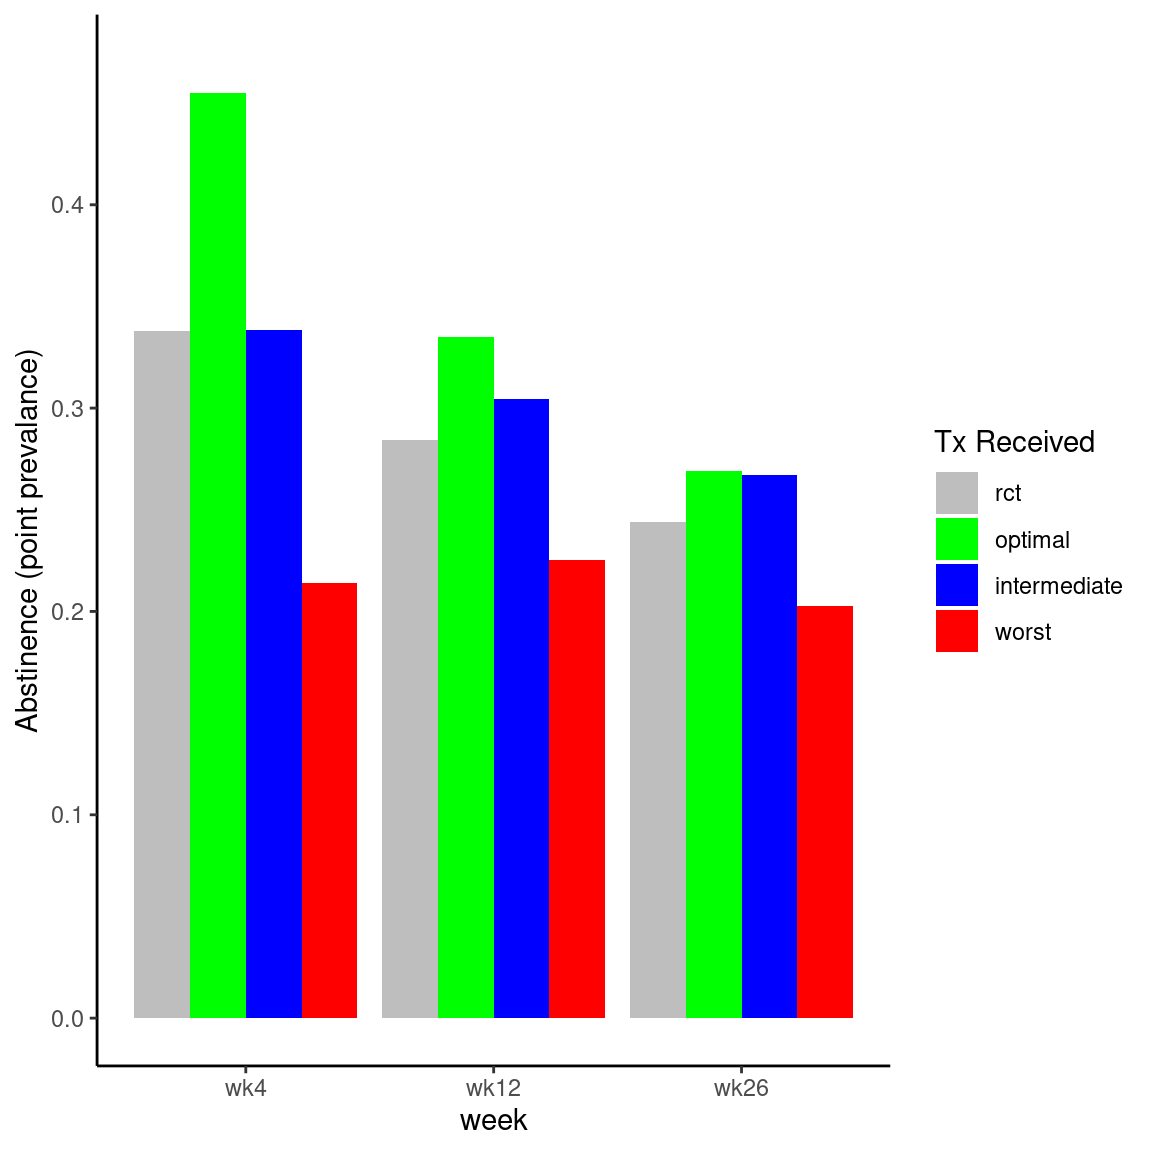

In [ ]:
#| label: fig-tx_week_5
#| fig-cap: "Abstince Rate over Time by Tx Received"
#| fig-height: 6
#| fig-width: 6

d_rank |> 
  bind_rows(d_week) |> 
  plot_outcomes()